# VHSE-Based Prediction of Proteasomal Cleavage Sites

`Xie J, Xu Z, Zhou S, Pan X, Cai S, Yang L, et al. (2013) The VHSE-Based Prediction of Proteasomal Cleavage Sites. PLoS ONE 8(9): e74506.` [doi:10.1371/journal.pone.0074506](https://dx.doi.org/10.1371%2Fjournal.pone.0074506)

**Abstract**: "Prediction of proteasomal cleavage sites has been a focus of computational biology. Up to date, the predictive methods are mostly based on nonlinear classifiers and variables with little physicochemical meanings. In this paper, the physicochemical properties of 14 residues both upstream and downstream of a cleavage site are characterized by VHSE (principal component score vector of hydrophobic, steric, and electronic properties) descriptors. Then, the resulting VHSE descriptors are employed to construct prediction models by support vector machine (SVM). For both in vivo and in vitro datasets, *the performance of VHSE-based method is comparatively better than that of the well-known [PAProC](http://www.paproc.de/), [MAPPP](http://www.mpiib-berlin.mpg.de/MAPPP/), and [NetChop](http://www.cbs.dtu.dk/Services/NetChop) methods*. The results reveal that the *hydrophobic property of 10 residues both upstream and downstream of the cleavage site is a dominant factor affecting in vivo and in vitro cleavage specificities*, followed by residue’s electronic and steric properties. Furthermore, the difference in hydrophobic potential between residues flanking the cleavage site is proposed to favor substrate cleavages. Overall, the interpretable VHSE-based method provides a preferable way to predict proteasomal cleavage sites."

Notes:

* Databases used in this study to create training and test sets
    * [Immune Epitope Database and Analysis Resource](http://www.iedb.org/)
    * [NCBI's reference sequence (RefSeq) database](http://www.ncbi.nlm.nih.gov/RefSeq/)
    * [AntiJen](http://www.ddg-pharmfac.net/antijen/AntiJen/antijenhomepage.htm) - a kinetic, thermodynamic and cellular database v2.0
    * [ExPASy/SWISS-PROT](http://www.expasy.org/)



## Biological Information

<a href="https://en.wikipedia.org/wiki/Major_histocompatibility_complex"><img src="MHC_Class_I_processing.png" width="320" align="right" alt="From Wikipedia" border="0"/></a>

Text from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2913210/

Cytotoxic T lymphocytes (CTLs) are the effector cells of the adaptive immune response that deal with infected, or malfunctioning, cells. Whereas intracellular pathogens are shielded from antibodies, CTLs are endowed with the ability to recognize and destroy cells harbouring intracellular threats. This obviously requires that information on the intracellular protein metabolism (including that of any intracellular pathogen) be translocated to the outside of the cell, where the CTL reside. To this end, the immune system has created an elaborate system of antigen processing and presentation. During the initial phase of antigen processing, peptide antigens are generated from intracellular pathogens and translocated into the endoplasmic reticulum. **In here, these peptide antigens are specifically sampled by major histocompatibility complex (MHC) class I molecules and then exported to the cell surface, where they are presented as stable peptide: MHC I complexes awaiting the arrival of scrutinizing T cells.** Hence, identifying which peptides are able to induce CTLs is of general interest for our understanding of the immune system, and of particular interest for the development of vaccines and immunotherapy directed against infectious pathogens, as previously reviewed. Peptide binding to MHC molecules is the key feature in cell-mediated immunity, because it is the peptide–MHC class I complex that can be recognized by the T-cell receptor (TCR) and thereby initiate the immune response. The CTLs are CD8+ T cells, whose TCRs recognize foreign peptides in complex with MHC class I molecules. In addition to peptide binding to MHC molecules, several other events have to be considered to be able to explain why a given peptide is eventually presented at the cell surface. Generally, an immunogenic peptide is generated from proteins expressed within the presenting cell, and peptides originating from proteins with high expression rate will normally have a higher chance of being immunogenic, compared with peptides from proteins with a lower expression rate. There are, however, significant exceptions to this generalization, e.g. cross-presentation, but this will be ignored in the following. In the classical MHC class I presenting pathway (*see image on right*) proteins expressed within a cell will be degraded in the cytosol by the protease complex, named the **proteasome**. **The proteasome digests polypeptides into smaller peptides 5–25 amino acids in length and is the major protease responsible for generating peptide C termini**. Some of the peptides that survive further degradation by other cytosolic exopeptidases can be bound by the transporter associated with antigen presentation (TAP), reviewed by Schölz et al. This transporter molecule binds peptides of lengths 9–20 amino acids and transports the peptides into the endoplasmic reticulum, where partially folded MHC molecules [in humans called human leucocyte antigens (HLA)], will complete folding if the peptide is able to bind to the particular allelic MHC molecule. The latter step is furthermore facilitated by the endoplasmic-reticulum-hosted protein tapasin. Each of these steps has been characterized and their individual importance has been related to final presentation on the cell surface.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.preprocessing import MinMaxScaler

The principal component score **V**ector of **H**ydrophobic, **S**teric, and **E**lectronic properties (VHSE) is 
a set of amino acid descriptors that come from [A new set of amino acid descriptors and its application in peptide QSARs](http://onlinelibrary.wiley.com/doi/10.1002/bip.20296/abstract)

* VHSE1 and VHSE2 are related to hydrophobic (H) properties, 
* VHSE3 and VHSE4 to steric (S) properties, and 
* VHSE5 to VHSE8 to electronic (E) properties.

In [2]:
# (3-letter, VHSE1, VHSE2, VHSE3, VHSE4, VHSE5, VHSE6, VHSE7, VHSE8)
vhse = {
"A": ("Ala", 0.15, -1.11, -1.35, -0.92, 0.02, -0.91, 0.36, -0.48),
"R": ("Arg", -1.47, 1.45, 1.24, 1.27, 1.55, 1.47, 1.30, 0.83),
"N": ("Asn", -0.99, 0.00, -0.37, 0.69, -0.55, 0.85, 0.73, -0.80),
"D": ("Asp", -1.15, 0.67, -0.41, -0.01, -2.68, 1.31, 0.03, 0.56),
"C": ("Cys", 0.18, -1.67, -0.46, -0.21, 0.00, 1.20, -1.61, -0.19),
"Q": ("Gln", -0.96, 0.12, 0.18, 0.16, 0.09, 0.42, -0.20, -0.41),
"E": ("Glu", -1.18, 0.40, 0.10, 0.36, -2.16, -0.17, 0.91, 0.02),
"G": ("Gly", -0.20, -1.53, -2.63, 2.28, -0.53, -1.18, 2.01, -1.34),
"H": ("His", -0.43, -0.25, 0.37, 0.19, 0.51, 1.28, 0.93, 0.65),
"I": ("Ile", 1.27, -0.14, 0.30, -1.80, 0.30, -1.61, -0.16, -0.13),
"L": ("Leu", 1.36, 0.07, 0.26, -0.80, 0.22, -1.37, 0.08, -0.62),
"K": ("Lys", -1.17, 0.70, 0.70, 0.80, 1.64, 0.67, 1.63, 0.13),
"M": ("Met", 1.01, -0.53, 0.43, 0.00, 0.23, 0.10, -0.86, -0.68),
"F": ("Phe", 1.52, 0.61, 0.96, -0.16, 0.25, 0.28, -1.33, -0.20),
"P": ("Pro", 0.22, -0.17, -0.50, 0.05, -0.01, -1.34, -0.19, 3.56),
"S": ("Ser", -0.67, -0.86, -1.07, -0.41, -0.32, 0.27, -0.64, 0.11),
"T": ("Thr", -0.34, -0.51, -0.55, -1.06, 0.01, -0.01, -0.79, 0.39),
"W": ("Trp", 1.50, 2.06, 1.79, 0.75, 0.75, -0.13, -1.06, -0.85),
"Y": ("Tyr", 0.61, 1.60, 1.17, 0.73, 0.53, 0.25, -0.96, -0.52),
"V": ("Val", 0.76, -0.92, 0.17, -1.91, 0.22, -1.40, -0.24, -0.03)}


There were eight dataset used in this study. The reference datasets (s1, s3, s5, s7) were converted into the actual datasets used in the analysis (s2, s4, s6, s8) using the `vhse` vector. The s2 and s4 datasets were used for training the SVM model and the s6 and s8 were used for testing.

In [3]:
%ls data/proteasomal_cleavage

s1_in_vivo_mhc_1_antijen_swiss_prot_reference.csv
s2_in_vivo_mhc_1_antijen_swiss_prot_dataset.csv
s3_in_vitro_from_iedb_ncbi_reference.csv
s4_in_vitro_from_iedb_ncbi_dataset.csv
s5_in_vivo_mhc_1_ligands_reference.csv
s6_in_vivo_mhc_1_ligands_dataset.csv
s7_in_vitro_ssx2_hivnef_rui_reference.csv
s8_in_vitro_ssx2_hivnef_rui_dataset.csv


In [4]:
# Converts the raw input into our X matrix and y vector. The 'peptide_key'
# and 'activity_key' parameters are the names of the column in the dataframe
# for the peptide amino acid string and activity (not cleaved/cleaved) 
# respectively. The 'sequence_len' allows for varying the number of flanking
# amino acids to cleavage site (which is at position 14 of 28 in each cleaved
# sample.
def dataset_to_X_y(dataframe, peptide_key, activity_key, sequence_len = 28):
    raw_peptide_len = 28
    if (sequence_len % 2 or sequence_len > raw_peptide_len or sequence_len <= 0):
        raise ValueError("sequence_len needs to an even value (0,%d]" % (raw_peptide_len))
    X = []
    y = []
    for (peptide, activity) in zip(dataframe[peptide_key], dataframe[activity_key]):
        if (len(peptide) != raw_peptide_len):
            print "Skipping peptide! len(%s)=%d. Should be len=%d" \
                               % (peptide, len(peptide), raw_peptide_len)
            continue
        y.append(activity)

        num_amino_acids_to_clip = (raw_peptide_len - sequence_len) / 2
        clipped_peptide = peptide if num_amino_acids_to_clip == 0 else \
                        peptide[num_amino_acids_to_clip:-num_amino_acids_to_clip]
        row = []
        for amino_acid in clipped_peptide:
            # There is a single peptide in dataset s6 with an "'" in the sequence.
            # The VHSE values used for it in the study match Proline (P).
            if amino_acid == "\'":
                amino_acid = "P"
            row.append(vhse[amino_acid][1]) # hydrophobic
            row.append(vhse[amino_acid][3]) # steric
            row.append(vhse[amino_acid][5]) # electric
        X.append(row)
    return (X, y)

# In Vivo Data

The training set **Sequence** is the amino acid sequence (all of which are 28 amino acids long). The **Activity** column is '1' for the cleavage case (n=2607) and '-1' for the non-cleavage case (n=2480). There are 28 x 8 **VHSE** columns representing the eight VHSE scores for each amino acid in the polypeptide.

Note: the cleavage site is at position 14 in each of the datasets.

## Training In Vivo Data

NOTE: The authors state that "the optimal values of C, ε and γ are determined by the results of 10-fold cross-validation." but they did not provide the parameters used. The following code was used to estimate the best 'C' value for the linear svm (the γ value is only used for the 'rbf' kernel).

```
# Note: in scikit 0.18, GridSearchCV is in 'model_selection'
from sklearn.grid_search import GridSearchCV
parameters = {'kernel': ['linear'], 'C': [1, 10, 30, 100]} 
clf = GridSearchCV(svr, parameters, cv=10, n_jobs=8, scoring='roc_auc')
import warnings
warnings.filterwarnings('ignore')
clf.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
```

In [5]:
training_set = pd.DataFrame.from_csv("data/proteasomal_cleavage/s2_in_vivo_mhc_1_antijen_swiss_prot_dataset.csv")
shuffled_training_set = training_set.sample(frac=1)
# NOTE: We need to use this same scaler to transform our testing data in order to get correct results
scaler = MinMaxScaler()
(X_train_prescaled, y_train) = dataset_to_X_y(shuffled_training_set, "Sequence", "Activity", sequence_len = 20)
X_train = pd.DataFrame(scaler.fit_transform(X_train_prescaled))
svr = svm.LinearSVC(C=10)
svr.fit(X_train, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Testing In Vivo SVM Model

In [6]:
testing_set = pd.DataFrame.from_csv("data/proteasomal_cleavage/s6_in_vivo_mhc_1_ligands_dataset.csv")
(X_test_prescaled, y_test) = dataset_to_X_y(testing_set, "Sequences", "Activity", sequence_len = 20)
X_test = pd.DataFrame(scaler.transform(X_test_prescaled))

y_predicted = svr.predict(X_test)

Skipping peptide! len(VMRETLFIGSHVVLRELRLNVTTQGPN)=27. Should be len=28
Skipping peptide! len(LCLFSYHRLRDLLLIVTRIVELLGRRG)=27. Should be len=28


In [7]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_predicted)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted, pos_label=1)
mcc = metrics.matthews_corrcoef(y_test, y_predicted)

print "Accuracy: %.2f, False Pos. Rate: %.2f, True Pos. Rate: %.2f, MCC=%.2f" %(accuracy, fpr[1], tpr[2], mcc)

Accuracy: 0.72, False Pos. Rate: 0.33, True Pos. Rate: 1.00, MCC=0.44


<IPython.core.display.Javascript object>


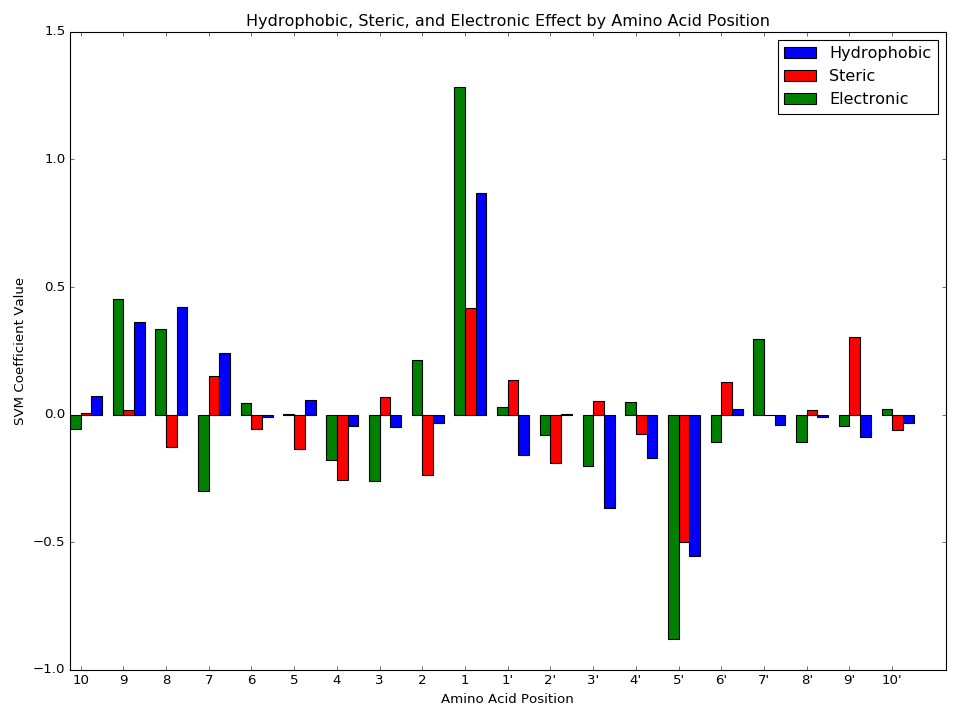

In [8]:
h = svr.coef_[:, 0::3]
s = svr.coef_[:, 1::3]
e = svr.coef_[:, 2::3]

%matplotlib notebook

n_groups = h.shape[1]

fig, ax = plt.subplots(figsize=(12,9))

index = np.arange(n_groups)
bar_width = 0.25

ax1 = ax.bar(index + bar_width, h.T, bar_width, label="Hydrophobic", color='b')
ax2 = ax.bar(index, s.T, bar_width, label="Steric", color='r')
ax3 = ax.bar(index - bar_width, e.T, bar_width, label="Electronic", color='g')

ax.set_xlim(-bar_width,len(index)+bar_width)

plt.xlabel('Amino Acid Position')
plt.ylabel('SVM Coefficient Value')
plt.title('Hydrophobic, Steric, and Electronic Effect by Amino Acid Position')
plt.xticks(index, range (n_groups/2, 0, -1) + [str(i)+"'" for i in range (1, n_groups/2+1)])
plt.legend()

plt.tight_layout()
plt.show()

